### take the ori2ori image from 1.main and use the lidar dense depth map

In [1]:
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from sensorFusionDataset.creatDataset_lidar import CreateDatasets
from sensorFusionDataset.data_split import split_dataset
from sensorFusionNetwork.simpleAutoencoder import SimpleAutoencoder
from testLoop import test_loop
from trainLoop import train_loop
from visualization import plot_losses, plot_metrics,plotTraining
from earlystopping import EarlyStopping

import h5py as h5
from datetime import datetime
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import time

local_time =time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())[-8:-1]
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
# CPU OR GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

img_path = 'image_gray_200_original'
lidar_path = 'lidar_tesor_200_dense'

img_list = sorted(glob.glob(img_path + '/*'))[0:7200]
lidar_list = sorted(glob.glob(lidar_path + '/*'))[0:7200]

print(len(img_list),len(lidar_list))
batch_size = 32
learning_rate = 1e-4
epochs = 600

MyDataset = CreateDatasets(img_list, lidar_list)
train_dataset, test_dataset, val_dataset = split_dataset(MyDataset, 0.7, 0.2)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
                          drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0,
                         drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0,
                        drop_last=True)

# print(len(train_loader))

patience = 50	# 当验证集损失在连续20次训练周期中都没有得到降低时，停止模型训练，以防止模型过拟合
save_path = 'model_save/'
early_stopping = EarlyStopping(save_path = save_path, patience = patience)	

new_model = SimpleAutoencoder()
new_model.to(device)
new_model.load_state_dict(torch.load('model_save/ori2ori/ori2ori_best_model_600_32_20230518_044338.pth'))

# fix the decoder
for name, value in new_model.named_parameters():
    #print (name) # print(model.state_dict().keys())
    if name.startswith('decoder'):
        value.requires_grad = False
        
params = filter(lambda p: p.requires_grad, new_model.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)
# optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

criterion = nn.MSELoss()
criterion.to(device)

training_loss = []
training_baseloss = []
test_loss = []
testing_baseloss = []
hisLrC = []
min_loss=10000

print (f'loading fertig! {device}' )

7200 7200
loading fertig! cuda


In [2]:
start_time = time.time()
for epoch in range(1, epochs + 1):
    # monitor training loss
    ##############################
    # start training the model #
    ##############################
    hisLrC.append(epoch)
    train_epoch_loss, train_epoch_baseloss = train_loop(train_loader, new_model, criterion, optimizer, device)
    training_loss.append(train_epoch_loss)
    # training_baseloss.append(train_epoch_baseloss)
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \t{:.0f}s'.format(epoch, epochs, train_epoch_loss,
                                                                  time.time() - start_time))

    ##############################
    # start testing the model #
    ##############################
    with torch.no_grad():
        test_epoch_loss, test_epoch_baseloss = test_loop(test_loader, new_model, criterion, device)
        test_loss.append(test_epoch_loss)
        # testing_baseloss.append(test_epoch_baseloss)
        
    # type(train_epoch_loss)) ---> float
    # writer.add_scalars('loss', {'training loss': train_epoch_loss, 'test loss': test_epoch_loss}, epoch)

        
    if test_epoch_loss < min_loss:
        min_loss = test_epoch_loss
        best_model_wts = copy.deepcopy(new_model.state_dict())
       

    if epoch == epochs:
        torch.save(best_model_wts, 'model_save/lidar2img/3_lidar2img_best_model_{}_{}_{}.pth'.format(epochs, batch_size,dt_string))
        print('best_testloss:{:.3f}\t epoch:{}'.format(min_loss, test_loss.index(min_loss)))     

    # 早停止
    date = dt_string
    early_stopping(test_epoch_loss, new_model, date)
    #达到早停止条件时，early_stop会被置为True
    if early_stopping.early_stop:
        torch.save(best_model_wts, 'model_save/lidar2img/3_lidar2img_best_model_{}_{}_{}.pth'.format(epochs, batch_size,dt_string))
        print('best_testloss:{:.3f}\t epoch:{}'.format(min_loss, test_loss.index(min_loss)))  
        print("Early stopping")
        break #跳出迭代，结束训练    
    
# train_baseline = sum(training_baseloss)/len(training_baseloss)
# test_baseline = sum(testing_baseloss)/len(training_baseloss)
# psnr_baseline = np.mean(psnr_base_list)

# train_baseline=train_baseline.item()
# test_baseline =test_baseline.item()
last_trainingloss = training_loss[-1]
last_testloss = test_loss[-1]


# write the dataset in one existed h5-file
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")

lossTrainArr = np.array(training_loss)
lossTestArr = np.array(test_loss)
bestLoss = np.array([min_loss])
LrCArr = np.array(hisLrC)

h5f =h5.File(f"log/recording_{dt_string}.hdf5","w")
# h5f = h5.File('train/train.h5', 'r+') # write in an exsited h5 file
g1 = h5f.create_group('log1')
g1.attrs['data']=now.strftime("%Y-%m-%d")
# g1.attrs['model']=ModelWts
# g1.attrs['optLrOrg']=str(optLrOrg)+'={:3.1e}'.format(optLrOrg) 
# g1.attrs['lrAdstep']= str(lrAdstep)
# g1.attrs['optimizer']= str(optimizer)[:4]

g1.create_dataset('lossTrain', data=lossTrainArr)
g1.create_dataset('lossTest', data=lossTestArr)
g1.create_dataset('bestLoss', data=bestLoss)
g1.create_dataset('LrCArr', data=LrCArr)
h5f.close()






Epoch: 1/600 	Training Loss: 2.863489 	107s
Epoch: 2/600 	Training Loss: 2.325342 	144s
Epoch: 3/600 	Training Loss: 2.290399 	157s
Epoch: 4/600 	Training Loss: 2.257288 	170s
Epoch: 5/600 	Training Loss: 2.229799 	184s
Epoch: 6/600 	Training Loss: 2.208478 	197s
Epoch: 7/600 	Training Loss: 2.184800 	210s
Epoch: 8/600 	Training Loss: 2.179791 	223s
EarlyStopping counter: 1 out of 50
Epoch: 9/600 	Training Loss: 2.165687 	236s
Epoch: 10/600 	Training Loss: 2.154681 	249s
EarlyStopping counter: 1 out of 50
Epoch: 11/600 	Training Loss: 2.152013 	263s
Epoch: 12/600 	Training Loss: 2.137835 	276s
EarlyStopping counter: 1 out of 50
Epoch: 13/600 	Training Loss: 2.136644 	289s
EarlyStopping counter: 2 out of 50
Epoch: 14/600 	Training Loss: 2.126032 	302s
Epoch: 15/600 	Training Loss: 2.124743 	315s
EarlyStopping counter: 1 out of 50
Epoch: 16/600 	Training Loss: 2.124899 	328s
EarlyStopping counter: 2 out of 50
Epoch: 17/600 	Training Loss: 2.117124 	341s
EarlyStopping counter: 3 out of 50

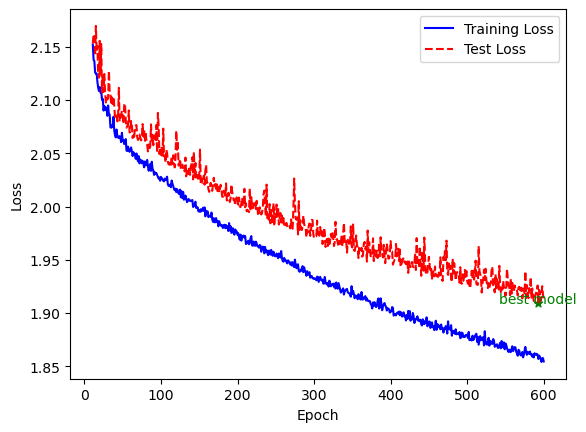

In [3]:
# # plot training and test
# f = h5.File('Experiment2_sequence_inverse/log/recording_20230509_232651.hdf5','r')

# lossTrainArr = f['log1']['lossTrain'][:]
# lossTestArr = f['log1']['lossTest'][:]
# bestLoss = f['log1']['bestLoss'][:]
# LrCArr = f['log1']['LrCArr'][:]

zoomin = 10
zoomout = 600
plotTraining(lossTrainArr, lossTestArr, LrCArr, bestLoss, zoomin, zoomout)

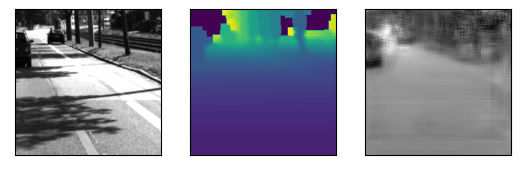

In [4]:
##################################################
# visualize one batch of the validation images #
##################################################
# test_model.to(device)
test_model_best = SimpleAutoencoder()
# test_model_last.load_state_dict(torch.load('model_save/damage_{}/last_model_{}.pth'.format(damage_label, experimentIndex)))
test_model_best.load_state_dict(
    # torch.load('model_save/damage_{}/best_model_{}_{}_{}.pth'.format(damage_label, epochs, batch_size,learning_rate))
    torch.load('model_save/lidar2img/3_lidar2img_best_model_600_32_20230518_154020.pth')
)

# 01_sensor_fusion/Coding/sensorFusion/Experiment2_sequence_inverse/lidar2img_model/best_model_300_32_20230501_141654.pth

test_model_best.eval()

# obtain one batch of test images
dataiter = iter(val_loader)
ori_img, noi_img = next(dataiter)

# get sample outputs
output = test_model_best(noi_img)

# prep images for display
# for i in range(ori_img.shape[0]):
for i in range(32):
    img1 = ori_img[i].numpy()
    img1 = img1.transpose(1, 2, 0)
    img2 = noi_img[i].numpy()
    img2 = img2.transpose(1, 2, 0)
    img3 = output[i].detach().numpy()
    img3 = img3.transpose(1, 2, 0)


    ax = plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('original image')
    plt.imshow(img1,cmap='gray')

    ax = plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('noisy image')
    plt.imshow(img2)
    # plt.colorbar()

    # cmap='gray'
    ax = plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('denoised image')
    plt.imshow(img3,cmap='gray')

    plt.savefig('output_save/3_main_lidar2img_600/{}.png'.format(i))
# plt.show()

In [6]:
import cv2
from PIL import Image
from torchvision import transforms

##################################################
# visualize one batch of the validation images #
##################################################
# load the best/last model
# test_model_last = SimpleAutoencoder()
test_model_best = SimpleAutoencoder()
# test_model_last.load_state_dict(torch.load('model_save/damage_{}/last_model_{}.pth'.format(damage_label, experimentIndex)))
test_model_best.load_state_dict(
    # torch.load('model_save/damage_{}/best_model_{}_{}_{}.pth'.format(damage_label, epochs, batch_size,learning_rate))
    torch.load('model_save/lidar2img/3_lidar2img_best_model_600_32_20230518_154020.pth')
    # torch.load('denoising_model/best_model_300_32_0.0004_20230424_144726.pth')
)

# test_model.to(device)
# test_model_last.eval()
test_model_best.eval()
# obtain one batch of validation images
# for batch_index, dataiter in enumerate (val_loader)
dataiter = iter(val_loader)
# print (type(next(dataiter)))
ori_img, noi_img = next(dataiter)
# ori_img, noi_img = next(dataiter) # 2. batch


# get sample outputs
# output = test_model_last(noi_img)
output = test_model_best(noi_img)


toPIL = transforms.ToPILImage()

# print(output.shape)
# prep images for display
for i in range(32):
    img1 = ori_img[i]
    img2 = noi_img[i]
    img3 = output[i]
    # print(img1.shape, img3.shape)
    # print(type(img1),type(img3))
    # im1 = toPIL(img1)
    # im2 = toPIL(img2)
    im3 = toPIL(img3)
    name = '%02d' %i

    # im1.save('output_save/ori_img/{}.png'.format(name))
    # im2.save('output_save/lidar_dense/{}.png'.format(name))
    im3.save('output_save/3_main_lidar2img_reconstructed_600/{}.png'.format(name))

In [7]:

# mse

# load the best/last model
test_model_best = SimpleAutoencoder()

test_model_best.load_state_dict(
    torch.load('model_save/lidar2img/3_lidar2img_best_model_600_32_20230518_154020.pth')
)

test_model_best.eval()

# obtain one batch of test images
dataiter = iter(val_loader)
ori_img, noi_img = next(dataiter)
# ori_img, noi_img = next(dataiter)
# ori_img, noi_img = next(dataiter)

# get sample outputs
# output = test_model_last(noi_img)
output = test_model_best(noi_img)




In [8]:
# mse
count = 0
batch_size = 32
for i in range (batch_size):
    img1 = ori_img[i]
    img3 = output[i]
    mse = criterion(img1,img3)
    mse = round(mse.item(),6)
    count = count+mse

mse_mean = count
print (f' {round(mse_mean,6)}')


 2.171349


In [9]:
# SSIM

import torch
from skimage.metrics import structural_similarity as ssim
from sensorFusionDataset.creatDataset import CreateDatasets
import glob
from torch.utils.data import DataLoader
from sensorFusionNetwork.simpleAutoencoder import SimpleAutoencoder

# dataset_path = '../../Dataset/lidar_img_16200/damaged_image_gray_all/DamagedDatasetforComparison'
# noi_img_list = sorted(glob.glob(dataset_path + '/*'))
# CAM_FRONT_path = '../../Dataset/lidar_img_16200/original_image_gray'
# img_list = sorted(glob.glob(CAM_FRONT_path + '/*'))[14400:14656]

metric_value_list = []
batch_size = 32

# ValDataset = CreateDatasets(img_list, noi_img_list)
# new_valloader = DataLoader(dataset=ValDataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

test_model_best = SimpleAutoencoder()
test_model_best.load_state_dict(torch.load('model_save/lidar2img/3_lidar2img_best_model_600_32_20230518_154020.pth'))

for i, batch in enumerate(val_loader):
    ori_img, noi_img = batch
    test_model_best.eval()
    output = test_model_best(noi_img)
    count = 0
    for j in range(ori_img.size(0)):
        ori_img_np = ori_img[j][0].detach().cpu().numpy()
        output_np = output[j][0].detach().cpu().numpy()
        ssim_img, diff = ssim(ori_img_np, output_np, full=True, data_range=1.0)
        count = count + ssim_img
    ssim_img = round(count / ori_img.size(0), 3)
    metric_value_list.append(ssim_img)

print(metric_value_list)

[0.324, 0.327, 0.322, 0.342, 0.317, 0.327, 0.338, 0.333, 0.318, 0.324, 0.311, 0.326, 0.348, 0.303, 0.336, 0.321, 0.338, 0.344, 0.336, 0.334, 0.32, 0.331]


In [10]:
print(round(sum(metric_value_list)/len(metric_value_list),6))

0.328182


In [11]:
# LLIPS metrics

import lpips

from sensorFusionDataset.creatDataset import CreateDatasets
import glob
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from sensorFusionDataset.creatDataset import CreateDatasets
from sensorFusionNetwork.simpleAutoencoder import SimpleAutoencoder
import numpy as np
import torch



metric_value_list =[]
batch_size = 32



test_model_best = SimpleAutoencoder()
# test_model_last.load_state_dict(torch.load('model_save/damage_{}/last_model_{}.pth'.format(damage_label, experimentIndex)))
test_model_best.load_state_dict(
    torch.load('model_save/lidar2img/3_lidar2img_best_model_600_32_20230518_154020.pth')
)

loss_fn = lpips.LPIPS(net='alex')


for i, batch in enumerate(val_loader):  # i -->index of batch
    if i == 0:
        ori_img, noi_img = batch
        test_model_best.eval()
        output = test_model_best(noi_img)
        count = 0
        # for j in range(ori_img.size(0)):
        # ori_img_np = ori_img[j][0].detach().numpy()
        # output_np = output[j][0].detach().numpy()
        lpips_img = loss_fn.forward(ori_img, output) # --> one batch lpips
        # print(lpips_img.shape) # --> torch.Size([32, 1, 1, 1])

        sum_result = (torch.sum(lpips_img)).item()
        print(round(sum_result,6))
        # count = count+sum_result
            # count = count.item()
        lpips_img_mean = round(sum_result/ori_img.size(0),3)
        print(round(lpips_img_mean,6)) # --> one batch lpips
        # metric_value_list.append(lpips_img)

# print(f'scuccess: {sum(metric_value_list)/len(metric_value_list)}')


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/Anaconda3-2021.11-Linux-x86_64/envs/pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
18.317999
0.572
